In [1]:
import numpy as np
import pandas as pd
import math

df = pd.read_csv("filtered_protacs.csv")
f = open("dc50_labels.txt", "r")
lines = f.readlines()
refined_lines = []
for l in lines:
    l = l.replace("(n/a)", "")
    l = l.replace("\n", "")
    l = l.replace(">", "")
    l = l.replace("<", "")
    l = l.replace("=", "")
    refined_lines.append(l)

final_labels = []
for l in refined_lines:
    arr = l.split('/')
    if len(arr) > 1:
        smallest_so_far = 999999
        for el in arr:
            if el == "":
                continue
            if el.find("~") > 0 or el.find("-") > 0:
                continue
            el = float(el)
            if el < smallest_so_far:
                smallest_so_far = el
        final_labels.append(smallest_so_far)
    else:
        final_labels.append(arr[0])

target_proteins = np.array(list(df["Target Protein"]))
e3_targets = np.array(list(df["E3 Target"]))
warheads = np.array(list(df["Warhead"]))
linkers = np.array(list(df["Linker"]))
e3_ligands = np.array(list(df["E3 Ligand"]))

labeled_indices = []
for i, val in enumerate(final_labels):
    val = str (val)
    if val == "":
        continue
    else:
        labeled_indices.append(i)
        
target_proteins = target_proteins[labeled_indices]
e3_targets = e3_targets[labeled_indices]
warheads = warheads[labeled_indices]
linkers = linkers[labeled_indices]
e3_ligands = e3_ligands[labeled_indices]
final_labels = np.array(final_labels)
my_labels = final_labels[labeled_indices]

print(len(target_proteins))
print(len(e3_targets))
print(len(warheads))
print(len(linkers))
print(len(e3_ligands))
print(len(my_labels))

903
903
903
903
903
903


In [2]:
from tqdm import tqdm as tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
from sklearn.preprocessing import normalize
from itertools import product

def sequence_to_kmer(protein_seq, k):
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range(0, len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range(0, len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct, ind))
    
    V=np.zeros(int((math.pow(7,k))))
    try:
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]] += 1
    except:
        count={'1':0,'2':0,'3':0, '4':0, '5':0,'6':0,'7':0}
        for q in range(0,len(protein_seq)):
            if protein_seq[q]=='A' or protein_seq[q]=='V' or protein_seq[q]=='G':
                count['1']+=1
            if protein_seq[q]=='I' or protein_seq[q]=='L'or protein_seq[q]=='F' or protein_seq[q]=='P':
                count['2']+=1
            if protein_seq[q]=='Y' or protein_seq[q]=='M'or protein_seq[q]=='T' or protein_seq[q]=='S':
                count['3']+=1
            if protein_seq[q]=='H' or protein_seq[q]=='N'or protein_seq[q]=='Q' or protein_seq[q]=='W':
                count['4']+=1
            if protein_seq[q]=='R' or protein_seq[q]=='K':
                count['5']+=1
            if protein_seq[q]=='D' or protein_seq[q]=='E':
                count['6']+=1
            if protein_seq[q]=='C':
                count['7']+=1
        
        value=list(count.values())
        key=list(count.keys())
        maximum_occurence=0
        index=0
        for t in range(0, len(value)):
            if maximum_occurence < value[t]:
                maximum_occurence = value[t]
                index=t
        maximum_occurence = key[index] # group number of maximum occuring group
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                if kmer[l] not in groups:
                    c += maximum_occurence
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]] += 1
            
        V = V/(len(protein_seq)-1)
        return np.array(V)
    

def get_protein_features(protein_sequence):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f = []
    protein_info = ProteinAnalysis(str(protein_sequence))
    protein_info.molecular_weight()
    amino_acid_percent = protein_info.get_amino_acids_percent()
    dp = []
    for a in aa:
        dp.append(amino_acid_percent[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    twomer=np.array(sequence_to_kmer(str(protein_sequence), 2))
    twomer=normalize(np.atleast_2d(twomer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(twomer[0])
    threemer=np.array(sequence_to_kmer(str(protein_sequence), 3))
    threemer=normalize(np.atleast_2d(threemer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(threemer[0])
    return np.array(f)

In [3]:
import pandas as pd
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt

from pysmiles import read_smiles
import networkx as nx
from tqdm import tqdm as tqdm
import warnings
warnings.filterwarnings("ignore")

# get smiles features
molecule_to_atomic_number = {
    "C":6,
    "O":8,
    "N":7,
    "S":16,
    "Cl":17,
    "F":7,
    "Br":35,
    "I":53,
    "P":15
}

MATRIX_SIZE = 50

linker_adjacency_matrices = []
linker_graph_features = []
warhead_adjacency_matrices = []
warhead_graph_features = []
e3_ligand_adjacency_matrices = []
e3_ligand_graph_features = []

for i in range(len(target_proteins)):
    if "[R2]" in e3_ligands[i]:
        e = e3_ligands[i].replace("[R2]", "")
    else:
        e = e3_ligands[i]
    
    l = str (linkers[i])
    if l == "nan":
        noLinker = True
    else:
        noLinker = False
        
    if noLinker:
        linker_X = np.zeros(MATRIX_SIZE)
        linker_X.resize(MATRIX_SIZE)
        linker_graph_features.append(linker_X)
        linker_A = np.zeros(MATRIX_SIZE*MATRIX_SIZE)
        linker_A.resize(MATRIX_SIZE*MATRIX_SIZE)
        linker_A = np.reshape(linker_A, (MATRIX_SIZE, MATRIX_SIZE))
        linker_adjacency_matrices.append(linker_A)
    else:
        linker = read_smiles(linkers[i])
        linker_elements = nx.get_node_attributes(linker, name = "element")
        linker_X = []
        for val in linker_elements.values():
            linker_X.append(molecule_to_atomic_number[val])
        linker_X = np.array(linker_X)
        linker_X.resize(MATRIX_SIZE)
        linker_graph_features.append(linker_X)
        linker_A = nx.adjacency_matrix(linker, weight='order').todense() 
        linker_A = np.array(linker_A)
        linker_A.resize(MATRIX_SIZE*MATRIX_SIZE)
        linker_A = np.reshape(linker_A, (MATRIX_SIZE, MATRIX_SIZE))
        linker_adjacency_matrices.append(linker_A)
        
    warhead = read_smiles(warheads[i])
    e3_ligand = read_smiles(e)
    
    warhead_elements = nx.get_node_attributes(warhead, name = "element")
    e3_ligand_elements = nx.get_node_attributes(e3_ligand, name = "element")

    warhead_X = []
    for val in warhead_elements.values():
        warhead_X.append(molecule_to_atomic_number[val])

    e3_ligand_X = []
    for val in e3_ligand_elements.values():
        e3_ligand_X.append(molecule_to_atomic_number[val])
        
    warhead_X = np.array(warhead_X)
    e3_ligand_X = np.array(e3_ligand_X)
    
    warhead_X.resize(MATRIX_SIZE)
    e3_ligand_X.resize(MATRIX_SIZE)
    
    warhead_graph_features.append(warhead_X)
    e3_ligand_graph_features.append(e3_ligand_X)
    
    warhead_A = nx.adjacency_matrix(warhead, weight='order').todense() 
    e3_ligand_A = nx.adjacency_matrix(e3_ligand, weight='order').todense() 
    
    warhead_A = np.array(warhead_A)
    e3_ligand_A = np.array(e3_ligand_A)
    
    warhead_A.resize(MATRIX_SIZE*MATRIX_SIZE)
    warhead_A = np.reshape(warhead_A, (MATRIX_SIZE, MATRIX_SIZE))
    
    e3_ligand_A.resize(MATRIX_SIZE*MATRIX_SIZE)
    e3_ligand_A = np.reshape(e3_ligand_A, (MATRIX_SIZE, MATRIX_SIZE))
    
    warhead_adjacency_matrices.append(warhead_A)
    e3_ligand_adjacency_matrices.append(e3_ligand_A)

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informati

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical i

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informatio

E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemica

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains s

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochem

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

In [4]:
warhead_adjacency_matrices = np.array(warhead_adjacency_matrices)
warhead_graph_features = np.array(warhead_graph_features)
linker_adjacency_matrices = np.array(linker_adjacency_matrices)
linker_graph_features = np.array(linker_graph_features)
e3_ligand_adjacency_matrices = np.array(e3_ligand_adjacency_matrices)
e3_ligand_graph_features = np.array(e3_ligand_graph_features)
print(warhead_adjacency_matrices.shape)
print(warhead_graph_features.shape)

(903, 50, 50)
(903, 50)


In [5]:
hidden_neurons = MATRIX_SIZE
output_size = 240
Weight_0 = np.random.randn(MATRIX_SIZE, hidden_neurons) * 0.05
Weight_1 = np.random.randn(hidden_neurons, output_size) * 0.05
# Weight_2 = np.random.randn(hidden_neurons, hidden_neurons) * 0.05
# Weight_3 = np.random.randn(hidden_neurons, output_size) * 0.05

# ReLU
def relu(x):
    return np.maximum(0, x)

def gcn(A, H, W):
    graph = nx.from_numpy_matrix(A)
    self_loops = []
    for i in range(graph.number_of_nodes()):
        self_loops.append((i, i))

    graph.add_edges_from(self_loops)
    A_with_self_loops = nx.to_numpy_array(graph)
    D = np.diag(np.sum(A_with_self_loops, axis=1))  
    D_half_norm = fractional_matrix_power(D, -0.5)
    result = D_half_norm.dot(A_with_self_loops).dot(D_half_norm).dot(H).dot(W)
    return relu(result)

def forward_pass(matrix, features, first_weight, second_weight):
    H1 = gcn(matrix, features, first_weight)
    H2 = gcn(matrix, H1, second_weight)
   
    return H2

linker_data = []
for i in tqdm(range(len(linker_graph_features))):
    example = forward_pass(linker_adjacency_matrices[i], linker_graph_features[i], Weight_0, Weight_1)
    linker_data.append(example)
    
warhead_data = []
for i in tqdm(range(len(warhead_graph_features))):
    example = forward_pass(warhead_adjacency_matrices[i], warhead_graph_features[i], Weight_0, Weight_1)
    warhead_data.append(example)
    
e3_ligand_data = []
for i in tqdm(range(len(e3_ligand_graph_features))):
    example = forward_pass(e3_ligand_adjacency_matrices[i], e3_ligand_graph_features[i], Weight_0, Weight_1)
    e3_ligand_data.append(example)

linker_data = np.array(linker_data)
warhead_data = np.array(warhead_data)
e3_ligand_data = np.array(e3_ligand_data)

print(linker_data.shape)
print(warhead_data.shape)
print(e3_ligand_data.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 903/903 [00:02<00:00, 313.01it/s]

(903, 240)
(903, 240)
(903, 240)


In [6]:
labels = []
for m in my_labels:
    if m.find("~") > 0:
        m.split("~")
        m = float (m[0])
        labels.append(m)
    elif m.find("-") > 0:
        m.split("-")
        m = float (m[0])
        labels.append(m)
    else:
        m = float (m)
        labels.append(m)
        
target_protein_features = []
e3_target_features = []
for i in tqdm(range(len(target_proteins))):
    p = get_protein_features(target_proteins[i])
    et = get_protein_features(e3_targets[i])
    target_protein_features.append(p)
    e3_target_features.append(et)
    
target_protein_features = np.array(target_protein_features)
e3_target_features = np.array(e3_target_features)
print(target_protein_features.shape)
print(e3_target_features.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 903/903 [00:10<00:00, 84.92it/s]

(903, 412)
(903, 412)


In [7]:
dataset = np.column_stack((target_protein_features, e3_target_features,
                           warhead_data, e3_ligand_data, linker_data))

print(dataset.shape)

labels = []
for m in my_labels:
    if m.find("~") > 0:
        m.split("~")
        m = float (m[0])
        labels.append(m)
    elif m.find("-") > 0:
        m.split("-")
        m = float (m[0])
        labels.append(m)
    else:
        m = float (m)
        labels.append(m)
        
labels = np.array(labels)
labels = np.log(labels)

(903, 1544)


(903, 2)


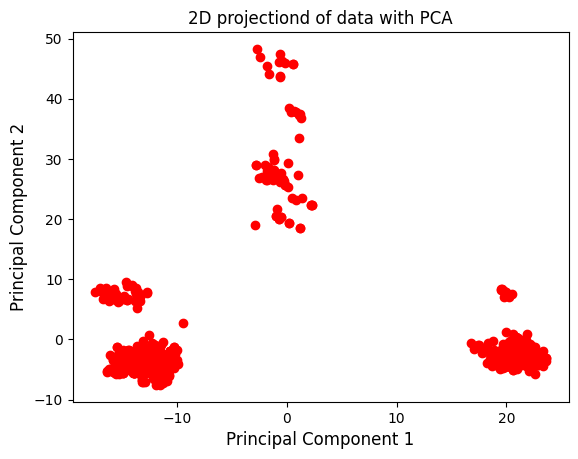

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LinearRegression, Ridge


# standardise data
scaler = StandardScaler(with_mean=True, with_std=True)
standardised_dataset = scaler.fit_transform(dataset)

# PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(standardised_dataset)
print(X_reduced.shape)

plt.scatter(X_reduced[:,0], X_reduced[:,1], color="r", label="data")
plt.title("2D projectiond of data with PCA")
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.show()

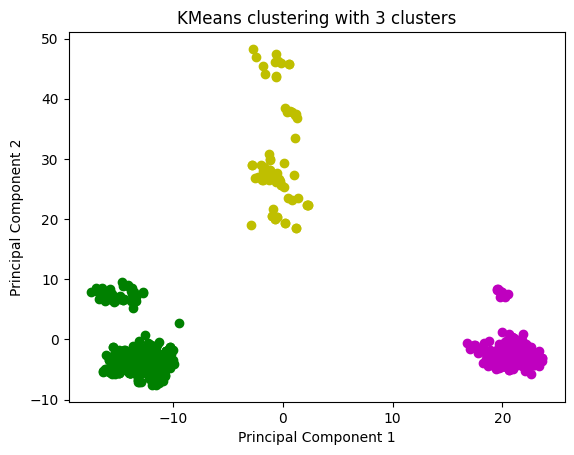

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_reduced)

cluster_0_indices = []
cluster_1_indices = []
cluster_2_indices = []

for i, k in enumerate(kmeans.labels_):
    if k == 0:
        cluster_0_indices.append(i)
    elif k == 1:
        cluster_1_indices.append(i)
    elif k == 2:
        cluster_2_indices.append(i)
        
# print(len(cluster_0_indices))
# print(len(cluster_1_indices))
# print(len(cluster_2_indices))

X_0 = X_reduced[cluster_0_indices]
X_1 = X_reduced[cluster_1_indices]
X_2 = X_reduced[cluster_2_indices]

plt.scatter(X_0[:,0], X_0[:,1], color='m', label="cluster 1")
plt.scatter(X_1[:,0], X_1[:,1], color='g', label="cluster 2")
plt.scatter(X_2[:,0], X_2[:,1], color='y', label="cluster 3")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans clustering with 3 clusters")
plt.show()

data_0 = []
for i in cluster_0_indices:
    ex = [dataset[i], labels[i]]
    data_0.append(ex)
    
data_1 = []
for i in cluster_1_indices:
    ex = [dataset[i], labels[i]]
    data_1.append(ex)
    
data_2 = []
for i in cluster_2_indices:
    ex = [dataset[i], labels[i]]
    data_2.append(ex)

# print(len(data_2[0][0]))

cluster_0_counter = 0
cluster_1_counter = 0
cluster_2_counter = 0
fold_0 = []
fold_1 = []
fold_2 = []

i = 0
while i < len(data_0):
    fold_0.append([data_0[i][0], data_0[i][1]])
    i += 1
    if i >= len(data_0):
        break
    fold_1.append([data_0[i][0], data_0[i][1]])
    i += 1
    if i >= len(data_0):
        break
    fold_2.append([data_0[i][0], data_0[i][1]])
    i += 1
    
    
i = 0
while i < len(data_1):
    fold_0.append([data_1[i][0], data_1[i][1]])
    i += 1
    if i >= len(data_1):
        break
    fold_1.append([data_1[i][0], data_1[i][1]])
    i += 1
    if i >= len(data_1):
        break
    fold_2.append([data_1[i][0], data_1[i][1]])
    i += 1
   
    
i = 0
while i < len(data_2):
    fold_0.append([data_2[i][0], data_2[i][1]])
    i += 1
    if i >= len(data_2):
        break
    fold_1.append([data_2[i][0], data_2[i][1]])
    i += 1
    if i >= len(data_2):
        break
    fold_2.append([data_2[i][0], data_2[i][1]])
    i += 1

# fold_0 = np.array(fold_0)
# fold_1 = np.array(fold_1)
# fold_2 = np.array(fold_2)
# print(fold_0[0][1])
# print(fold_1.shape)
# print(fold_2.shape)


120 components explains more than 95% of the data variance


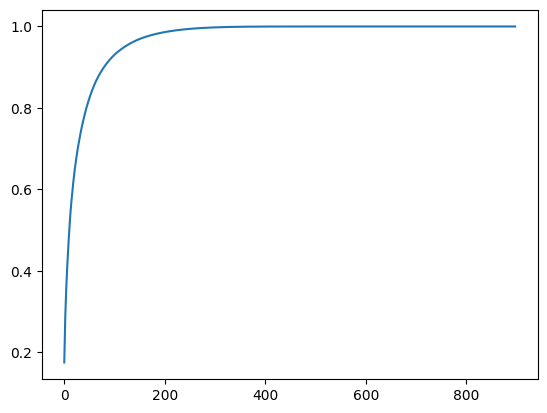

In [10]:
# Scree graph of PCA
scree_pca = PCA(n_components=898).fit(standardised_dataset)
cumulative_explained_variance = np.cumsum(scree_pca.explained_variance_ratio_)
for i, c in enumerate(cumulative_explained_variance):
    if c > 0.95:
        print(i, "components explains more than 95% of the data variance")
        no_of_features = i
        break
plt.plot(cumulative_explained_variance)

rmse: 1.7306098955678089    r2: 0.6343822144946761    spearman: 0.7486490421666124    pearson: 0.7974142369400008
rmse: 1.7610271212267181    r2: 0.6205253715239627    spearman: 0.7464106030322157    pearson: 0.7911865606824404
rmse: 1.7919454746267252    r2: 0.6413452891926734    spearman: 0.7529233833180561    pearson: 0.8021400176853671


******Performance of XGBoost******
root mean square error:  1.761194163807084
pearson correlation coefficient:  0.7969136051026028
spearman correlation coefficient:  0.7493276761722947
r2 score:  0.632084291737104
root mean square error:  1.761194163807084
pearson correlation coefficient:  0.7969136051026028
spearman correlation coefficient:  0.7493276761722947
r2 score:  0.632084291737104
std of root mean square error:  0.025040423878745666
std of pearson correlation coefficient:  0.004485720251063624
std of spearman correlation coefficient:  0.002701787661056902
std of r2 score:  0.008653615031988995


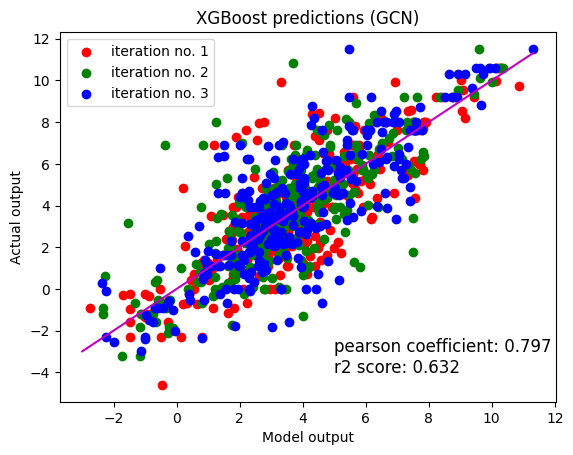

In [11]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []
colors = ['r', 'g', 'b']

for i in range(3):
    color = colors[i]
    if i == 0:
        train_dataset = fold_0 + fold_1
        val_dataset = fold_2
    elif i == 1:
        train_dataset = fold_0 + fold_2
        val_dataset = fold_1
    else:
        train_dataset = fold_1 + fold_2
        val_dataset = fold_0
    
    examples = []
    my_labels = []
    for j in range(len(train_dataset)):
        examples.append(train_dataset[j][0])
        my_labels.append(train_dataset[j][1])
    examples = np.array(examples)
    my_labels = np.array(my_labels)
    
    test_examples = []
    test_labels = []
    for k in range(len(val_dataset)):
        test_examples.append(val_dataset[k][0])
        test_labels.append(val_dataset[k][1])
    test_examples = np.array(test_examples)
    answers = np.array(test_labels)
    
    model.fit(examples, my_labels)
    outputs = model.predict(test_examples)
    coeffr, _ = pearsonr(answers, outputs)
    coeffs, _ = spearmanr(answers, outputs)
    rmse = math.sqrt(mean_squared_error(answers, outputs))
    r2 = r2_score(answers, outputs)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
    print("rmse:", rmse, "  ", "r2:", r2, "  ", "spearman:", coeffs, "  ", "pearson:", coeffr)
    s = "iteration no. " + str (i+1)
    plt.scatter(outputs, answers, color=color, label=s)
    if min(outputs) < min(answers):
        minimum = min(outputs)
    else:
        minimum = min(answers)
    
    if max(outputs) < max(answers):
        maximum = max(outputs)
    else:
        maximum = max(answers)
    y = np.linspace(minimum, maximum)
    x = y
 

print()
print()
print("******Performance of XGBoost******") 
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())
print("std of root mean square error: ", np.array(rmse_scores).std())
print("std of pearson correlation coefficient: ", np.array(pearson_scores).std())
print("std of spearman correlation coefficient: ", np.array(spearman_scores).std())
print("std of r2 score: ", np.array(r2_scores).std())

plt.plot(x, y, color='m') # plot line y=x
plt.xlabel("Model output")
plt.ylabel("Actual output")
plt.title("XGBoost predictions (GCN)")
plt.legend()
plt.text(5.0, -3.0, "pearson coefficient: " + str (round(np.array(pearson_scores).mean(), 3)), fontsize=12)
plt.text(5.0, -4.0, "r2 score: " + str (round(np.array(r2_scores).mean(), 3)), fontsize=12)
plt.show()
    


rmse: 1.691687503140696    r2: 0.6506431760379988    spearman: 0.7708615746629895    pearson: 0.8071028543592691
rmse: 1.7252302795506709    r2: 0.6357959263140188    spearman: 0.7608081325491456    pearson: 0.7983222096275004
rmse: 1.789102171369719    r2: 0.6424825504378419    spearman: 0.7646024152195209    pearson: 0.806267449498068


******Performance of Random Forest******
root mean square error:  1.7353399846870285
pearson correlation coefficient:  0.8038975044949458
spearman correlation coefficient:  0.765424040810552
r2 score:  0.6429738842632865
std of root mean square error:  0.04040675686070945
std of pearson correlation coefficient:  0.003957053614728325
std of spearman correlation coefficient:  0.004145216202080076
std of r2 score:  0.006071313025893468


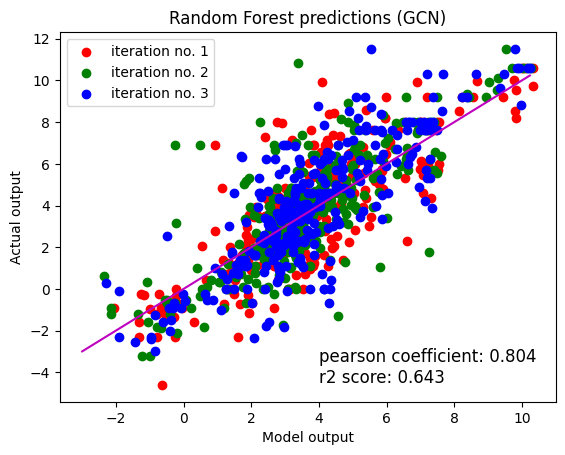

In [16]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=1000, max_depth=23, random_state=0, criterion="squared_error", max_features="sqrt")

rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []
colors = ['r', 'g', 'b']

for i in range(3):
    color = colors[i]
    if i == 0:
        train_dataset = fold_0 + fold_1
        val_dataset = fold_2
    elif i == 1:
        train_dataset = fold_0 + fold_2
        val_dataset = fold_1
    else:
        train_dataset = fold_1 + fold_2
        val_dataset = fold_0
    
    examples = []
    my_labels = []
    for j in range(len(train_dataset)):
        examples.append(train_dataset[j][0])
        my_labels.append(train_dataset[j][1])
    examples = np.array(examples)
    my_labels = np.array(my_labels)
    
    test_examples = []
    test_labels = []
    for k in range(len(val_dataset)):
        test_examples.append(val_dataset[k][0])
        test_labels.append(val_dataset[k][1])
    test_examples = np.array(test_examples)
    answers = np.array(test_labels)
    
    model.fit(examples, my_labels)
    outputs = model.predict(test_examples)
    coeffr, _ = pearsonr(answers, outputs)
    coeffs, _ = spearmanr(answers, outputs)
    rmse = math.sqrt(mean_squared_error(answers, outputs))
    r2 = r2_score(answers, outputs)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
    print("rmse:", rmse, "  ", "r2:", r2, "  ", "spearman:", coeffs, "  ", "pearson:", coeffr)
    s = "iteration no. " + str (i+1)
    plt.scatter(outputs, answers, color=color, label=s)
    if min(outputs) < min(answers):
        minimum = min(outputs)
    else:
        minimum = min(answers)
    
    if max(outputs) < max(answers):
        maximum = max(outputs)
    else:
        maximum = max(answers)
    y = np.linspace(minimum, maximum)
    x = y

   
print()
print()
print("******Performance of Random Forest******") 
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())
print("std of root mean square error: ", np.array(rmse_scores).std())
print("std of pearson correlation coefficient: ", np.array(pearson_scores).std())
print("std of spearman correlation coefficient: ", np.array(spearman_scores).std())
print("std of r2 score: ", np.array(r2_scores).std())

plt.plot(x, y, color='m') # plot line y=x
plt.xlabel("Model output")
plt.ylabel("Actual output")
plt.title("Random Forest predictions (GCN)")
plt.legend()
plt.text(4.0, -3.5, "pearson coefficient: " + str (round(np.array(pearson_scores).mean(), 3)), fontsize=12)
plt.text(4.0, -4.5, "r2 score: " + str (round(np.array(r2_scores).mean(), 3)), fontsize=12)
plt.show()
 

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 300.82it/s]


r2 score: 0.5254325739552212
spearman's rank corellation coefficient: 0.6923348595572592
pearson correlation coefficient: 0.7431148205547938
root mean squared error: 1.9716711798967204


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 363.48it/s]


r2 score: 0.5866345371540356
spearman's rank corellation coefficient: 0.7259820149821218
pearson correlation coefficient: 0.771349814132727
root mean squared error: 1.8379841685794438


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 445.56it/s]


r2 score: 0.6035379514942751
spearman's rank corellation coefficient: 0.737436814471697
pearson correlation coefficient: 0.7790590008574771
root mean squared error: 1.8840279065641146


******Performance of MLP******
AVERAGE R2 SCORE: 0.5718683542011773
AVERAGE SPEARMAN RANK CORELLATION COEFFICIENT: 0.7185845630036926
AVERAGE PEARSON CORELLATION COEFFICIENT 0.7645078785149994
AVERAGE ROOT MEAN SQUARED ERROR: 1.8978944183467596
std of root mean square error:  0.05545126605407721
std of pearson correlation coefficient:  0.015451107547266625
std of spearman correlation coefficient:  0.019141374142693606
std of r2 score:  0.033552373183601554


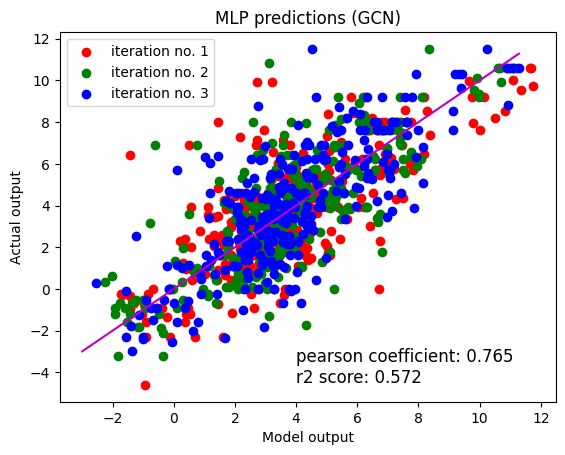

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable
USE_CUDA = torch.cuda.is_available() 

def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v


def toTensor(v,dtype = torch.float,requires_grad = False):       
    return cuda(Variable(v.clone().detach()).type(dtype).requires_grad_(requires_grad))


def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

# Hyperparameters
input_size = len(dataset[0]) #number of features
hidden_size = 250
output_size = 1
num_epochs = 1000
batch_size = 100
learning_rate = 0.0001


class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fcout = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out = self.fc1(x)
        out = self.leaky_relu(out)

        out = self.fc2(out)
        out = self.leaky_relu(out)

        out = self.fc3(out)
        out = self.tanh(out)

        out = self.fcout(out)
        return out
    
  
r2_scores = []
spearman_scores = []
pearson_scores = []
rmse_scores = []
colors = ['r', 'g', 'b']

for i in range(3):
    color = colors[i]
    if i == 0:
        train_dataset = fold_0 + fold_1
        val_dataset = fold_2
    elif i == 1:
        train_dataset = fold_0 + fold_2
        val_dataset = fold_1
    else:
        train_dataset = fold_1 + fold_2
        val_dataset = fold_0
        

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    
    model = cuda(Net(input_size, hidden_size, output_size))

    criterion = nn.MSELoss()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
   

    model.train()

    epoch_no = []
    all_losses = []
    for j, epoch in enumerate(range(num_epochs)):
        losses = []
        for examples, my_labels in train_loader:
            examples = toTensor(examples, dtype=torch.float32)
            my_labels = toTensor(my_labels, dtype=torch.float32)
            my_labels = my_labels.unsqueeze(1)
            optimizer.zero_grad()
            output = model(examples)
            loss = criterion(output, my_labels)
            my_loss = (float) (loss)
            losses.append(my_loss)
            loss.backward()
            optimizer.step()
        losses = np.array(losses)
        epoch_no.append(j+1)
        all_losses.append(losses.sum())

    outputs = []
    answers = []
    for examples, mylabels in tqdm(val_loader):
        with torch.no_grad():
            examples = toTensor(examples, dtype=torch.float32)
            output = model(examples)
            mylabels = mylabels.unsqueeze(1)
            for o in output:
                o = float (o)
                outputs.append(o)
            for l in mylabels:
                l = float(l)
                answers.append(l)       

    outputs = np.array(outputs)
    answers = np.array(answers)
    coeffr, _ = pearsonr(answers, outputs)
    coeffs, _ = spearmanr(answers, outputs)
    rmse = math.sqrt(mean_squared_error(answers, outputs))
    r2 = r2_score(answers, outputs)
    pearson_scores.append(coeffr)
    spearman_scores.append(coeffs)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    # plot graph of actual VS predicted output
    s = "iteration no. " + str (i+1)
    plt.scatter(outputs, answers, color=color, label=s)


    print("r2 score:", r2)
    print("spearman's rank corellation coefficient:", coeffs)
    print("pearson correlation coefficient:", coeffr)
    print("root mean squared error:", rmse)
   

r2_scores = np.array(r2_scores)
pearson_scores = np.array(pearson_scores)
spearman_scores = np.array(spearman_scores)
rmse_scores = np.array(rmse_scores)
print()
print()
print("******Performance of MLP******")
print("AVERAGE R2 SCORE:", r2_scores.mean())
print("AVERAGE SPEARMAN RANK CORELLATION COEFFICIENT:", spearman_scores.mean())
print("AVERAGE PEARSON CORELLATION COEFFICIENT", pearson_scores.mean())
print("AVERAGE ROOT MEAN SQUARED ERROR:", rmse_scores.mean())
print("std of root mean square error: ", np.array(rmse_scores).std())
print("std of pearson correlation coefficient: ", np.array(pearson_scores).std())
print("std of spearman correlation coefficient: ", np.array(spearman_scores).std())
print("std of r2 score: ", np.array(r2_scores).std())
    
if min(outputs) < min(answers):
    minimum = min(outputs)
else:
    minimum = min(answers)

if max(outputs) < max(answers):
    maximum = max(outputs)
else:
    maximum = max(answers)
y = np.linspace(minimum, maximum)
x = y
plt.plot(x, y, color='m') # plot line y=x
plt.xlabel("Model output")
plt.ylabel("Actual output")
plt.title("MLP predictions (GCN)")
plt.legend()
plt.text(4.0, -3.5, "pearson coefficient: " + str (round(np.array(pearson_scores).mean(), 3)), fontsize=12)
plt.text(4.0, -4.5, "r2 score: " + str (round(np.array(r2_scores).mean(), 3)), fontsize=12)
plt.show()